# Anchor-based multi-class classification

* p anchors per class
* k classes
* n features
* m examples

---

## Imports

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

## Get MNIST Data

In [ ]:
import mnist

data_train = mnist.train_images()
data_test = mnist.test_images()

labels_train = mnist.train_labels()
labels_test= mnist.test_labels()

## Prepare data

In [480]:
p = 5  # Number of anchor vectors per class
k = 10 # Number of classes

# X_train.shape = (784, 60000)
# X_test.shape  = (784, 10000)
# Y_train.shape = (10, 60000)
# Y_test.shape  = (10, 10000)

m_train, n, _ = data_train.shape
m_test, _, _ = data_test.shape 

normalize = lambda v: v/255 - 0.5

X_train = normalize(data_train.reshape(m_train, n**2).T)
X_test = normalize(data_test.reshape(m_test, n**2).T)

Y_train = np.eye(k)[labels_train].T
Y_test = np.eye(k)[labels_test].T

## Define functions

In [597]:
def random_mini_batches(X, Y, minibatch_size, seed):
    
    np.random.seed(seed)
    
    _, m = X.shape
    
    indices = np.array([i for i in range(m)])
    
    np.random.shuffle(indices)
    
    X = X[:, indices]
    Y = Y[:, indices]
    
    minibatches = []
    i = 0
    
    while i < m:
        
        minibatches.append((X[:, i:i+minibatch_size], Y[:, i:i+minibatch_size]))
        i += minibatch_size
    
    return minibatches

def create_placeholders(n, k):
    
    X = tf.placeholder(tf.float32, shape = [n, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [k, None], name = "Y")
    
    return X, Y

def initialize_params(k, p, n, A_init=None, learn_A=True):
    
    # k classes
    # p anchors
    # n features
    
    if type(A_init) != np.ndarray:
        A = tf.get_variable("A", 
                            [k, p, n], 
                            dtype = tf.float32, 
                            initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    else:
        if learn_A:
            A = tf.get_variable("A", 
                                dtype = tf.float32, 
                                initializer = tf.constant(A_init, dtype = tf.float32))
        else:
            A = tf.constant(A_init, name = "A", dtype = tf.float32)
        
    w = tf.get_variable("w", [k, 1], dtype = tf.float32, initializer = tf.zeros_initializer())
    b = tf.get_variable("b", [k, 1], dtype = tf.float32, initializer = tf.zeros_initializer())
    
    params = {
        "A": A,
        "w": w,
        "b": b
    }
                        
    return params

def forward_propagate(X, params):

    # A.shape = (k, p, n)
    # X.shape = (n, m)
    # w.shape = (k, 1)
    # b.shape = (k, 1)
    
    A = params["A"]
    w = params["w"]
    b = params["b"]
    
    k = tf.shape(A)[0]
    p = tf.shape(A)[1]
    m = tf.shape(X)[1]
    
    norm_A = tf.reshape(tf.norm(A, axis = 2), (k, p, 1))
    norm_X = tf.reshape(tf.norm(X, axis = 0), (1, m))
    norm = tf.tensordot(norm_A, norm_X, [[2], [0]])
    
    prod = tf.tensordot(A, X, [[2], [0]])
    
    sim = tf.divide(prod, norm) # shape = (k, p, m)
    dist = 1 - sim
    
    D = tf.reshape(tf.reduce_prod(dist, axis = 1), (k, m)) # shape = (k, m)
    H = tf.transpose(tf.nn.softmax(tf.transpose(w * D + b))) # shape = (k, m)
    
    return H

def get_cost(Y, H, epsilon = 0.0001):
    
    # Y.shape = (k, m)
    # H.shape = (k, m)
    
    m = tf.cast(tf.shape(Y)[1], "float32")
    L = - tf.reduce_sum(Y * tf.log(tf.maximum(H, epsilon)), axis = 0)
    cost = 1/m * tf.reduce_sum(L)
    
    return cost

def get_A_reg(A, q=0, epsilon = 0.0001):
    
    # A.shape = (k, p, n)
    
    if q == 0:
        return 0
    
    k = tf.shape(A)[0]
    p = tf.shape(A)[1]
    
    norm_A = tf.reshape(tf.norm(A, axis = 2), (k, p, 1))
    norm_A_T = tf.transpose(norm_A, perm = [0, 2, 1]) # shape = (k, 1, p)
    norm = tf.tensordot(norm_A, norm_A_T, [[1, 2], [2, 1]]) # shape = (k, p, p)
    
    prod = tf.tensordot(A, tf.transpose(A, perm = [0, 2, 1]), [[1, 2], [2, 1]])
    
    sim = tf.divide(prod, norm)
    dist = tf.maximum(1 - sim, epsilon)
    
    energy = 1/2 * tf.reduce_sum(q**2 / dist)
    
    return energy

# ##### -------------------------------------------------------- #####

def model(X_train, 
          Y_train, 
          X_test, 
          Y_test, 
          A_init = None,
          learn_A = True,
          p = 4,
          q = 0,
          learning_rate = 0.0001,
          num_epochs = 1500, 
          minibatch_size = 32, 
          print_cost = True):
    
    # X_train.shape = (n, m)
    # Y_train.shape = (p, m)
    
    tf.reset_default_graph()
    
    tf.set_random_seed(1)
    seed = 2
    
    (n, m) = X_train.shape
    k = Y_train.shape[0]
    J_train = []
    J_valid = []
    
    X, Y = create_placeholders(n, k)
    params = initialize_params(k, p, n, A_init, learn_A)
    H = forward_propagate(X, params)
    
    if learn_A:
        J = get_cost(Y, H) + get_A_reg(params["A"], q = q)
    else:
        J = get_cost(Y, H)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(J)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        tic = time()
        
        for epoch in range(num_epochs):

            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, J], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            
            if print_cost == True and epoch % 10 == 0:
                dt = time() - tic
                print ("Cost after epoch %i: %f (time elapsed = %f s)" % (epoch, epoch_cost, dt))
                
            if epoch % 2 == 0:
                J_train.append(epoch_cost)
                J_valid.append(sess.run(J, feed_dict = {X: X_test, Y: Y_test}))
        
        font = {"family": "Century Gothic", "weight": "normal", "size" : 14}
        plt.rc("font", **font)
        fig = plt.figure(figsize = (10, 7))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(np.squeeze(J_train), label = "J_train")
        ax.plot(np.squeeze(J_valid), label = "J_valid")
        ax.legend()
        ax.set_xlim([0, len(J_train)])
        ax.set_ylabel("Cost", fontdict = {"fontsize": 16, "weight": "bold"})
        ax.set_xlabel("Iteration", fontdict = {"fontsize": 16, "weight": "bold"})
        ax.set_title("%d Anchors: Charge = %g, Learning Rate = %g" % (p, q, learning_rate),
                     fontdict = {"fontsize": 24, "weight": "bold"})
        plt.show()
        
        params = sess.run(params)
        H_train = sess.run(H, feed_dict = {X: X_train})
        H_test = sess.run(H, feed_dict = {X: X_test})
        
        print("Training complete.")
        
        return (params, H_train, H_test, J_train, J_valid)

## Initialize A

In [604]:
labels_train.tolist()
examples = []

k = 10

for a in range(10):
    matches = np.array([i for i in range(len(labels_train)) if labels_train[i] == a])
    examples.append(matches[:k])
anchor_examples = np.array(examples)

A_initial = np.array([X_train[:, anchor_examples[i]].T for i in range(10)])
A_initial.shape

(10, 10, 784)

## Train Model

In [ ]:
result = model(X_train, 
               Y_train, 
               X_test, 
               Y_test, 
               A_init = A_initial,
               learn_A = True,
               p = 3,
               q = 0,
               learning_rate = 0.001,
               num_epochs = 31, 
               minibatch_size = 32, 
               print_cost = True)

Cost after epoch 0: 1.332424 (time elapsed = 9.146205 s)
Cost after epoch 10: 0.260645 (time elapsed = 100.805600 s)
Cost after epoch 20: 0.233902 (time elapsed = 198.649754 s)


In [611]:
params, H_train, H_test, J_train, J_valid = result
acc_train = sum(np.argmax(H_train, axis = 0) == labels_train)/len(labels_train)
acc_test = sum(np.argmax(H_test, axis = 0) == labels_test)/len(labels_test)

print("Train Accuracy: %f" % acc_train)
print(" Test Accuracy: %f" % acc_test)

Train Accuracy: 0.941267
 Test Accuracy: 0.933800


## Visualize Anchors

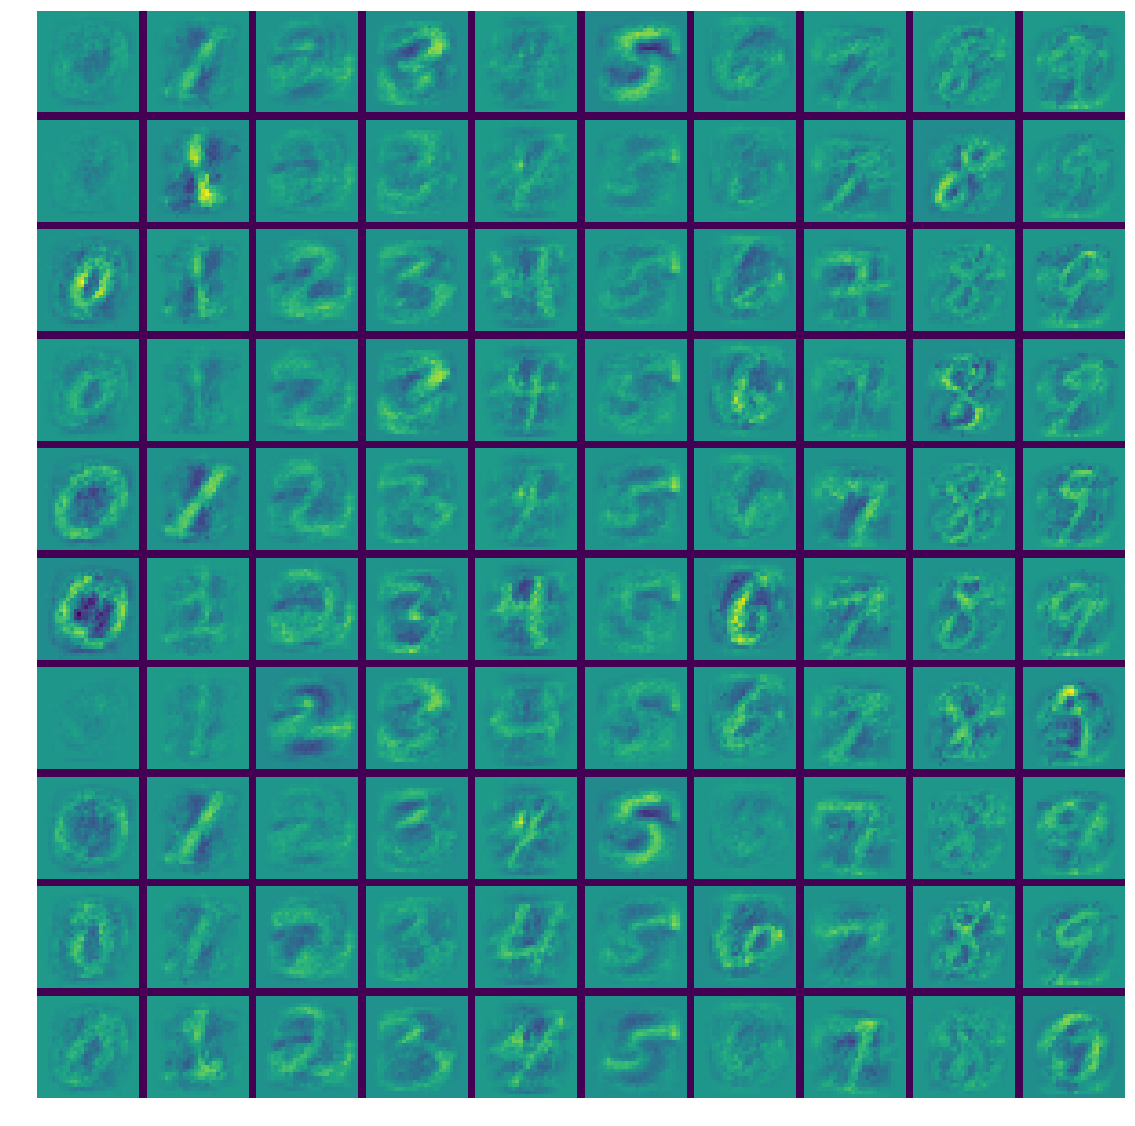

In [612]:
def v_concat(M, buffer=3):
    
    a, n_h, n_v = M.shape
    buffer_array = np.zeros((buffer, n_h))
    
    result = M[0]
    i = 0
    while i + 1 < a:
        result = np.concatenate([result, buffer_array, M[i + 1]], axis = 0)
        i += 1
    return result


def combine(A, buffer=3):
    
    k, p, n_h, n_v = A.shape
    buffer_array = np.zeros((buffer*(p - 1) + p*n_h, buffer))
    
    result = v_concat(A[0], buffer = buffer)
    
    i = 0
    while i + 1 < k:
        result = np.concatenate([result, buffer_array, v_concat(A[i + 1], buffer = buffer)], axis = 1)
        i += 1
    return result

##### ------------------------------------------ #####

k, p, n = params["A"].shape
A_params = np.reshape(params["A"], (k, p, 28, 28))
anchors = A_params - np.min(A_params)

fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(combine(anchors, buffer = 2))
ax.axis("off")
plt.show()

In [608]:
params["A"].shape

(10, 10, 784)

# Other

In [ ]:
def cos_dist(A, B):
    sim = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
    dist = 1 - sim
    return dist

cos_dist(X_test[:, 0], X_test[:, 1])

def norm(v):
    v = v.tolist()
    return sum([i ** 2 for i in v]) ** 0.5

def dot(v, w):
    v = v.tolist()
    w = w.tolist()
    s = sum([v[i] * w[i] for i in range(len(v))])
    return s

def man_cos_dist(v, w):
    sim = dot(v, w) / (norm(v) * norm(w))
    dist = 1 - sim
    return dist

X_0 = X_train[:, 6]
X_1 = X_train[:, 15]
man_cos_dist(X_0, X_1), cos_dist(X_0, X_1)

In [ ]:
k = 10
p = 5
n = 300
m = 1000

def make_2D(A):
    i, j, k = A.shape
    return np.reshape(A, (i * j, k))

A = np.random.randn(k, p, n)
X = np.random.randn(n, m)

A_norm_0 = np.reshape(np.linalg.norm(A, axis = 2), (k, p, 1))
A_norm_1 = np.reshape(np.linalg.norm(A, axis = 2), (k * p, 1))

X_norm_0 = np.reshape(np.linalg.norm(X, axis = 0), (1, m))

norm_0 = np.dot(A_norm_0, X_norm_0)
norm_1 = np.reshape(np.dot(A_norm_1, X_norm_0), (k, p, m))

A_1 = np.reshape(A, (k * p, n))

prod_0 = np.round(np.dot(A, X), 2)
prod_1 = np.round(np.dot(A_1, X), 2)
prod_0 == np.reshape(prod_1, (k, p, m))

In [ ]:
A = np.random.randn(2, 3, 4)
X = np.random.randn(4, 5)

np.round(np.dot(A, X), 2) == np.round(np.reshape(np.dot(make_2D(A), X), (2, 3, 5)), 2)

In [ ]:
A = np.random.randn(k, p, n)
X = np.random.randn(n, m)

with tf.Session() as sess:
    AA = tf.constant(A)
    XX = tf.constant(X)
    result = sess.run(tf.tensordot(A, X, [[2], [0]]))
    
np.round(np.dot(A, X), 2) == np.round(result, 2)

In [471]:
labels_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [419]:
labels_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [413]:
H_train.shape

(10, 60000)

In [277]:
Y_test[:, 1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [243]:
with tf.Session() as sess:
    logits = tf.constant(np.array([[1., 2.]]))
    hello = sess.run(tf.nn.softmax(logits))
    
print(hello)

[[0.26894142 0.73105858]]


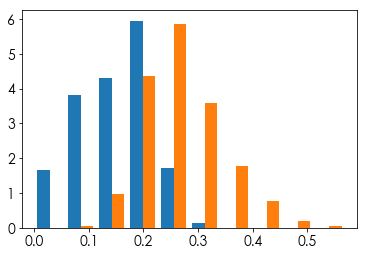

In [484]:
dists_match = []
dists_other = []
for i in range(10000):
    dist = man_cos_dist(X_train[:, 6], X_train[:, i])
    if labels_train[i] == 1:
        dists_match.append(dist)
    else:
        dists_other.append(dist)
    
plt.hist([dists_match, dists_other], normed = True)
plt.show()